# Подготовка среды



In [40]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070


In [41]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

import time
import statistics
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd

# Работа с моделью

Загружаем токенизатор и модель

In [42]:
tokenizer = AutoTokenizer.from_pretrained("Zyphra/Zamba2-1.2B-instruct")
model = AutoModelForCausalLM.from_pretrained("Zyphra/Zamba2-1.2B-instruct", device_map="cuda", torch_dtype=torch.bfloat16)

Тестовый запрос

In [43]:
prompt = "What factors contributed to the fall of the Roman Empire?"
sample = [{'role': 'user', 'content': prompt}]
chat_sample = tokenizer.apply_chat_template(sample, tokenize=False)

input_ids = tokenizer(chat_sample, return_tensors='pt', add_special_tokens=False)
device = next(model.parameters()).device
input_ids = {k: v.to(device) for k, v in input_ids.items()}

outputs = model.generate(
    **input_ids,
    max_new_tokens=150,
    return_dict_in_generate=False,
    output_scores=False,
    use_cache=True,
    num_beams=1,
    do_sample=False,
)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

user
What factors contributed to the fall of the Roman Empire? 
 assistant
There were several factors that contributed to the fall of the Roman Empire, including:

1. Economic problems: The Roman Empire faced economic difficulties due to inflation, over-taxation, and the cost of maintaining a vast empire.

2. Military problems: The Roman army was stretched thin, and the empire faced constant threats from barbarian tribes.

3. Political instability: The Roman Empire was plagued by political instability, with frequent changes in leadership and power struggles.

4. Social problems: The Roman Empire faced social problems such as poverty, inequality, and corruption.

5. Environmental factors: The Roman Empire faced environmental challenges such as droughts, floods, and


# Сбор данных и анализ модели

Функция для создания хуков, используемых для замера времени между слоями

In [44]:
def make_timed_hooks(name, module, layer_infos, scope="leaf", block_kind=None):
    def pre_hook(module, inputs):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        module._profiler_start = time.perf_counter()

    def post_hook(module, inputs, output):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.perf_counter()
        start = getattr(module, "_profiler_start", None)
        duration_ms = (end - start) * 1000.0 if start else 0.0

        entry = {
            "name": name,
            "type": module.__class__.__name__,
            "time_ms": duration_ms,
            "input_shapes": [],
            "output_shapes": None,
            "scope": scope,
            "block_kind": block_kind,
        }

        for inp in inputs:
            if isinstance(inp, torch.Tensor):
                entry["input_shapes"].append(tuple(inp.shape))
            else:
                entry["input_shapes"].append(str(type(inp)))

        if isinstance(output, torch.Tensor):
            entry["output_shapes"] = tuple(output.shape)
        elif isinstance(output, (tuple, list)):
            entry["output_shapes"] = [
                tuple(o.shape) if isinstance(o, torch.Tensor) else str(type(o))
                for o in output
            ]
        else:
            entry["output_shapes"] = str(type(output))

        try:
            import torch.nn as nn
            if isinstance(module, nn.Conv1d):
                entry["kernel_size"] = module.kernel_size[0]
        except Exception:
            pass

        layer_infos.append(entry)

    return pre_hook, post_hook

Функция регистрации хуков на модели

In [45]:
import torch.nn as nn

def register_hooks(model):
    layer_infos = []
    handles = []

    for name, module in model.named_modules():
        children = list(module.children())
        is_leaf = len(children) == 0

        if is_leaf:
            pre, post = make_timed_hooks(name, module, layer_infos, scope="leaf")
            h1 = module.register_forward_pre_hook(pre)
            h2 = module.register_forward_hook(post)
            handles.extend([h1, h2])

        block_kind = None
        if "mamba_decoder.mamba" in name:
            block_kind = "mamba_decoder"
        elif name.endswith(".mamba"):
            block_kind = "mamba"
        elif "shared_transformer" in name:
            block_kind = "shared_transformer"

        if block_kind is not None:
            pre_b, post_b = make_timed_hooks(
                name, module, layer_infos, scope="block", block_kind=block_kind
            )
            hb1 = module.register_forward_pre_hook(pre_b)
            hb2 = module.register_forward_hook(post_b)
            handles.extend([hb1, hb2])

    return layer_infos, handles

Функция удаления хуков

In [46]:
def remove_hooks(handles):
    for h in handles:
        try:
            h.remove()
        except Exception:
            pass

Функция подсчета FLOPS
* Linear, Conv1d - по формуле матричного/сверточного умножения
* Ядро внимания - отдельно добавляем стоимость QKᵀ и матричного умножения на V
* Mamba SSM - грубая оценка по формуле ~6 · B · L · D_ssm · d_state (по Mamba-пейперу)

In [47]:
MAMBA_D_STATE = 16 # оценка d_state из Mamba-пейпера

def _linear_flops(info):
    out_shape = info["output_shapes"]
    in_shapes = info["input_shapes"]

    if not isinstance(out_shape, tuple):
        return 0.0

    in_tensor_shape = None
    for s in in_shapes:
        if isinstance(s, tuple):
            in_tensor_shape = s
            break

    if in_tensor_shape is None:
        return 0.0

    out_f = out_shape[-1]
    in_f = in_tensor_shape[-1]

    num_positions = 1
    for d in out_shape[:-1]:
        num_positions *= d

    return 2.0 * num_positions * in_f * out_f


def _conv1d_flops(info):
    out_shape = info["output_shapes"]

    if not isinstance(out_shape, tuple) or len(out_shape) != 3:
        return 0.0

    B, C_out, L_out = out_shape

    C_in = None
    for s in info["input_shapes"]:
        if isinstance(s, tuple) and len(s) == 3:
            C_in = s[1]
            break

    if C_in is None:
        return 0.0

    kernel_size = info.get("kernel_size", 3)
    return 2.0 * B * C_out * L_out * C_in * kernel_size


def compute_flops_from_trace(layer_infos):
    """
    Оценивает FLOPs по трейсу:
      - Linear / Conv1d (по форме входа/выхода)
      - Attention ядро (QK^T и умножение на V) по self_attn.q_proj
      - Mamba SSM по mamba.norm выходу

    Возвращает словарь:
      {
        "total_linear_conv_flops": ...,
        "total_attn_kernel_flops": ...,
        "total_mamba_flops": ...,
        "total_flops": ...,
        "block_flops_total": {idx: ...},
        "block_flops_mamba": {idx: ...},
        "block_flops_attn": {idx: ...},
        "block_flops_ffn": {idx: ...},
      }
    """

    total_linear_conv_flops = 0.0
    total_attn_kernel_flops = 0.0
    total_mamba_flops = 0.0

    block_flops_total = defaultdict(float)
    block_flops_mamba = defaultdict(float)
    block_flops_attn = defaultdict(float)
    block_flops_ffn = defaultdict(float)

    for info in layer_infos:
        name = info['name']
        typ = info['type']
        out_shape = info['output_shapes']

        parts = name.split('.')
        block_idx = None
        if len(parts) > 2 and parts[0] == 'model' and parts[1] == 'layers':
            try:
                block_idx = int(parts[2])
            except Exception:
                block_idx = None
        
        flops_lc = 0.0
        if typ == 'Linear':
            flops_lc = _linear_flops(info)
        elif typ == 'Conv1d':
            flops_lc = _conv1d_flops(info)
        
        total_linear_conv_flops += flops_lc
        if block_idx is not None:
            block_flops_total[block_idx] += flops_lc

        if 'shared_transformer.self_attn' in name:
            if block_idx is not None:
                block_flops_attn[block_idx] += flops_lc
        elif "shared_transformer.feed_forward" in name:
            if block_idx is not None:
                block_flops_ffn[block_idx] += flops_lc
        elif ".mamba." in name or "mamba_decoder.mamba." in name:
            if block_idx is not None:
                block_flops_mamba[block_idx] += flops_lc

        if "shared_transformer.self_attn.q_proj" in name and isinstance(out_shape, tuple) and len(out_shape) == 3:
            B, L, D = out_shape
            flops_scores = 2.0 * B * (L ** 2) * D
            flops_values = 2.0 * B * (L ** 2) * D
            flops_attn_kernel = flops_scores + flops_values
            total_attn_kernel_flops += flops_attn_kernel
            if block_idx is not None:
                block_flops_attn[block_idx] += flops_attn_kernel
                block_flops_total[block_idx] += flops_attn_kernel

        if ".mamba.norm" in name and isinstance(out_shape, tuple) and len(out_shape) == 3:
            B, L, D_ssm = out_shape
            flops_mamba_ssm = 6.0 * B * L * D_ssm * MAMBA_D_STATE
            total_mamba_flops += flops_mamba_ssm
            if block_idx is not None:
                block_flops_mamba[block_idx] += flops_mamba_ssm
                block_flops_total[block_idx] += flops_mamba_ssm

    total_flops = total_linear_conv_flops + total_attn_kernel_flops + total_mamba_flops

    return {
        "total_linear_conv_flops": total_linear_conv_flops,
        "total_attn_kernel_flops": total_attn_kernel_flops,
        "total_mamba_flops": total_mamba_flops,
        "total_flops": total_flops,
        "block_flops_total": block_flops_total,
        "block_flops_mamba": block_flops_mamba,
        "block_flops_attn": block_flops_attn,
        "block_flops_ffn": block_flops_ffn,
    }

Функция для сбора статистики по модели

In [48]:
def extract_architecture(model, stats):
    """
    Собирает базовую архитектурную информацию:
      - количество блоков
      - наличие Mamba и shared_transformer в каждом блоке
      - число параметров модели
    """
    layers_arch = {}
    total_params = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv1d) or isinstance(module, nn.Embedding):
            for p in module.parameters(recurse=False):
                total_params += p.numel()

        parts = name.split(".")
        if not (len(parts) > 2 and parts[0] == "model" and parts[1] == "layers"):
            continue

        try:
            layer_idx = int(parts[2])
        except Exception:
            continue

        sub = ".".join(parts[3:])
        layer = layers_arch.setdefault(layer_idx, {
            "has_mamba": False,
            "has_mamba_decoder": False,
            "has_shared_transformer": False,
            "param_count": 0,
            "hidden_size": stats.get("hidden_size"),
            "ffn_dim": None,
            "flops_attn": 0.0,
            "flops_ffn": 0.0,
            "flops_mamba": 0.0,
            "tflops_effective": 0.0,
        })

        if "mamba_decoder.mamba" in sub:
            layer["has_mamba_decoder"] = True
        elif ".mamba." in sub:
            layer["has_mamba"] = True

        if "shared_transformer" in sub:
            layer["has_shared_transformer"] = True

        # Оценка ffn_dim по feed_forward.gate_up_proj
        if "shared_transformer.feed_forward.gate_up_proj" in sub and isinstance(module, nn.Linear):
            out_dim = module.weight.shape[0]
            layer["ffn_dim"] = out_dim

        # Параметры блока
        if isinstance(module, (nn.Linear, nn.Conv1d, nn.Embedding)):
            for p in module.parameters(recurse=False):
                layer["param_count"] += p.numel()

    return {
        "layers": layers_arch,
        "total_params": total_params,
        "model_type": model.__class__.__name__,
    }

In [49]:
def analyze_zamba(model, layer_infos, total_ms):
    """
    Формирует сводную статистику:
      - hidden_size, seq_len
      - время по типам модулей
      - время по блокам
      - FLOPs по компонентам (Linear+Conv1d, Attention kernel, Mamba SSM)
      - архитектуру (наличие Mamba / shared_transformer по блокам)
    """
    stats = {
        "by_type": defaultdict(list),
        "block_stats": {},
        "slowest": [],
        "hidden_size": None,
        "sequence_length": None,
        "total_forward_ms": total_ms,
    }

    # Базовая статистика по модулям
    for info in layer_infos:
        stats["by_type"][info["type"]].append(info["time_ms"])

        shape = info["output_shapes"]
        if isinstance(shape, tuple) and len(shape) == 3:
            B, L, D = shape
            if stats["hidden_size"] is None:
                stats["hidden_size"] = D
            if stats["sequence_length"] is None:
                stats["sequence_length"] = L

        # время по блокам (по leaf-модулям и блок-хукам)
        parts = info["name"].split(".")
        block_idx = None
        if len(parts) > 2 and parts[0] == "model" and parts[1] == "layers":
            try:
                block_idx = int(parts[2])
            except Exception:
                block_idx = None

        if block_idx is not None:
            bs = stats["block_stats"].setdefault(
                block_idx,
                {
                    "attn_time": 0.0,
                    "ffn_time": 0.0,
                    "mamba_time": 0.0,
                    "other_time": 0.0,
                    "total_time": 0.0,
                },
            )
            t = info["time_ms"]
            bs["total_time"] += t
            name = info["name"]

            if "shared_transformer.self_attn" in name:
                bs["attn_time"] += t
            elif "shared_transformer.feed_forward" in name:
                bs["ffn_time"] += t
            elif ".mamba." in name or "mamba_decoder.mamba" in name or info.get("block_kind") in ("mamba", "mamba_decoder"):
                bs["mamba_time"] += t
            else:
                bs["other_time"] += t

    # Самые медленные модули
    stats["slowest"] = sorted(layer_infos, key=lambda x: x["time_ms"], reverse=True)[:20]

    # FLOPs по трейсу
    flops_stats = compute_flops_from_trace(layer_infos)
    stats["total_flops_linear_conv"] = flops_stats["total_linear_conv_flops"]
    stats["total_flops_attn_kernel"] = flops_stats["total_attn_kernel_flops"]
    stats["total_flops_mamba"] = flops_stats["total_mamba_flops"]
    stats["total_flops"] = flops_stats["total_flops"]
    stats["block_flops_total"] = flops_stats["block_flops_total"]

    # эффективная производительность (по полной оценке FLOPs)
    if total_ms > 0:
        stats["effective_tflops_estimated"] = stats["total_flops"] / (total_ms / 1000.0) / 1e12
    else:
        stats["effective_tflops_estimated"] = 0.0

    # Архитектура
    arch = extract_architecture(model, stats)
    stats["arch"] = arch
    stats["total_params"] = arch["total_params"]
    stats["num_transformer_blocks"] = len(arch["layers"])

    # Сводка по типам модулей
    by_type_summary = {}
    for t, times in stats["by_type"].items():
        total_t = sum(times)
        count_t = len(times)
        by_type_summary[t] = {
            "count": count_t,
            "total_ms": total_t,
            "avg_ms": total_t / count_t if count_t > 0 else 0.0,
        }
    stats["by_type_summary"] = by_type_summary

    # Эффективность по блокам (по полной оценке FLOPs)
    for idx, layer in arch["layers"].items():
        block_time_ms = stats["block_stats"].get(idx, {}).get("total_time", 0.0)
        block_fl = flops_stats["block_flops_total"].get(idx, 0.0)

        # Разложение по компонентам
        layer["flops_attn"] = flops_stats["block_flops_attn"].get(idx, 0.0)
        layer["flops_ffn"] = flops_stats["block_flops_ffn"].get(idx, 0.0)
        layer["flops_mamba"] = flops_stats["block_flops_mamba"].get(idx, 0.0)

        if block_time_ms > 0 and block_fl > 0:
            tfl = block_fl / (block_time_ms / 1000.0) / 1e12
        else:
            tfl = 0.0
        layer["tflops_effective"] = tfl

    return stats

### Вспомогательные функции

Функция для построения графиков

In [50]:
def build_plots(layer_infos, stats, idx):
    df = pd.DataFrame(layer_infos)

    # Время по модулям
    plt.figure()
    plt.plot(df.index, df["time_ms"])
    plt.xlabel("Leaf/Block-модули")
    plt.ylabel("Время (мс)")
    plt.title("Время выполнения по модулям")
    plt.tight_layout()
    plt.savefig(f"layer_time_{idx}.png")
    plt.close()

    # Время по типам модулей
    plt.figure()
    df.groupby("type")["time_ms"].sum().sort_values().plot(kind="barh")
    plt.title("Время по типам модулей")
    plt.xlabel("мс")
    plt.tight_layout()
    plt.savefig(f"type_time_{idx}.png")
    plt.close()

    # Время по блокам
    if stats.get("block_stats"):
        block_df = pd.DataFrame.from_dict(stats["block_stats"], orient="index")
        plt.figure(figsize=(12, 6))
        block_df[["attn_time", "ffn_time", "mamba_time", "other_time"]].plot(kind="bar", stacked=True)
        plt.title("Время по Mamba-блокам")
        plt.xlabel("Блок")
        plt.ylabel("мс")
        plt.tight_layout()
        plt.savefig(f"block_time_{idx}.png")
        plt.close()

Функция для выдачи отчета о модели

In [51]:
def fmt(n):
    return f"{n:,}".replace(",", " ") if n is not None else "N/A"


def write_md_report(name, stats, total_ms, idx):
    total_flops = stats["total_flops"]
    total_linear_conv = stats["total_flops_linear_conv"]
    total_attn = stats["total_flops_attn_kernel"]
    total_mamba = stats["total_flops_mamba"]

    def pct(x):
        return (x / total_flops * 100.0) if total_flops > 0 else 0.0

    with open(f"report_{idx}.md", "w", encoding="utf-8") as f:
        f.write(f"# {name}\n\n")
        f.write("## Общие параметры\n")
        f.write(f"- Время forward-pass: {total_ms:.2f} ms\n")
        f.write(f"- Размер скрытого пространства: {stats['hidden_size']}\n")
        f.write(f"- Размер словаря: {tokenizer.vocab_size}\n")
        f.write(f"- Длина входной последовательности: {stats['sequence_length']}\n")
        f.write(f"- Количество блоков: {stats['num_transformer_blocks']}\n")
        f.write(f"- Количество параметров: {fmt(stats['total_params'])}\n\n")

        f.write("## FLOPs (оценка по трейсу)\n")
        f.write(f"- Linear + Conv1d: {total_linear_conv/1e9:.2f} GFLOPs ({pct(total_linear_conv):.1f}%)\n")
        f.write(f"- Attention kernel (QK^T + AV): {total_attn/1e9:.2f} GFLOPs ({pct(total_attn):.1f}%)\n")
        f.write(f"- Mamba SSM: {total_mamba/1e9:.2f} GFLOPs ({pct(total_mamba):.1f}%)\n")
        f.write(f"- Итого: {total_flops/1e9:.2f} GFLOPs\n")
        f.write(f"- Эффективная производительность: {stats['effective_tflops_estimated']:.2f} TFLOPs\n\n")

        f.write("## Графики\n")
        f.write(f"![](layer_time_{idx}.png)\n\n")
        f.write(f"![](type_time_{idx}.png)\n\n")
        f.write(f"![](block_time_{idx}.png)\n\n")

        arch_layers = stats["arch"]["layers"]
        if arch_layers:
            example_idx = min(arch_layers.keys())
            layer = arch_layers[example_idx]

            f.write("\n## Пример информации по одному блоку\n")
            f.write(f"- Номер блока: {example_idx}\n")
            f.write(f"- Есть Mamba-блок: {layer['has_mamba']}\n")
            f.write(f"- Есть Mamba decoder: {layer['has_mamba_decoder']}\n")
            f.write(f"- Есть shared Transformer: {layer['has_shared_transformer']}\n")
            f.write(f"- Размер скрытого пространства: {layer['hidden_size']}\n")
            f.write(f"- Размер внутреннего пространства FFN (если есть): {layer['ffn_dim']}\n")
            f.write(f"- FLOPs Attention: {layer['flops_attn']/1e9:.3f} GF\n")
            f.write(f"- FLOPs FFN: {layer['flops_ffn']/1e9:.3f} GF\n")
            f.write(f"- FLOPs Mamba: {layer['flops_mamba']/1e9:.3f} GF\n")

        f.write("\n### Эффективность по блокам\n")
        f.write("| Номер блока | Mamba (GF) | Attention (GF) | FFN (GF) | Эффективность (TFLOPs) |\n")
        f.write("|---|---|---|---|---|\n")

        block_indices = sorted(arch_layers.keys())
        for b in block_indices:
            l = arch_layers[b]
            tfl = l.get("tflops_effective", 0.0)
            f.write(
                f"| {b} | "
                f"{l['flops_mamba']/1e9:.3f} | "
                f"{l['flops_attn']/1e9:.3f} | "
                f"{l['flops_ffn']/1e9:.3f} | "
                f"{tfl:.2f} |\n"
            )

        f.write("\n## Сводная таблица времени по типам модулей\n")
        f.write("| Тип | Кол-во | Суммарное время (мс) | Среднее (мс) |\n")
        f.write("|-----|--------|------------------------|---------------|\n")
        for t, info_t in sorted(stats["by_type_summary"].items(),
                                key=lambda x: x[1]["total_ms"], reverse=True):
            f.write(f"| {t} | {info_t['count']} | {info_t['total_ms']:.3f} | {info_t['avg_ms']:.4f} |\n")

        f.write("\n## Самые медленные модули (20)\n")
        for entry in stats["slowest"]:
            f.write(f"- {entry['time_ms']:.3f} ms — `{entry['name']}` ({entry['type']})\n")

Функция для сохранения трейса слоев модели

In [52]:
def write_layers(layer_infos, idx):
    with open(f"layers_{idx}.txt", "w", encoding="utf-8") as f:
        for i, entry in enumerate(layer_infos):
            f.write(f"[{i:04d}] {entry['name']}\n")
            f.write(f"  Тип: {entry['type']}\n")
            f.write(f"  Время: {entry['time_ms']:.3f} ms\n")
            f.write(f"  Вход: {entry['input_shapes']}\n")
            f.write(f"  Выход: {entry['output_shapes']}\n")
            if entry.get("scope") == "block":
                f.write(f"  Scope: block ({entry.get('block_kind')})\n")
            f.write("\n")

### Запуск модели в режиме трассировки

In [53]:
def run_with_trace_zamba(tokenizer, model, prompts):
    results = []
    device = next(model.parameters()).device

    for idx, prompt in enumerate(prompts):
        print(f"\n=== Промпт {idx+1}/{len(prompts)} ({len(prompt.split())} слов) ===")
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        layer_infos, handles = register_hooks(model)

        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(**inputs)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            end = time.perf_counter()

        total_ms = (end - start) * 1000.0

        remove_hooks(handles)

        stats = analyze_zamba(model, layer_infos, total_ms)

        build_plots(layer_infos, stats, idx)
        write_md_report("Zamba2 1.2B", stats, total_ms, idx)
        print(f"Анализ сохранён в report_{idx}.md")

        write_layers(layer_infos, idx)
        print(f"Список модулей сохранен в layers_{idx}.txt")

        stats["prompt_idx"] = idx
        stats["prompt_length"] = inputs["input_ids"].shape[1]

        results.append(stats)
        print(
            f"Prompt {idx}: seq_len={stats['prompt_length']}, "
            f"total FLOPs (оценка)={stats['total_flops']/1e9:.2f} GF, time={total_ms:.2f} ms"
        )

    return results

In [54]:
prompts = [
    "Простой короткий промпт. ",
    "Простой короткий промпт. " * 2,
    "Простой короткий промпт. " * 3,
    "Простой короткий промпт. " * 5,
    "Простой короткий промпт. " * 7,
    "Простой короткий промпт. " * 10,
    "Простой короткий промпт. " * 14,
    "Простой короткий промпт. " * 18,
    "Простой короткий промпт. " * 25,
]

stats_list = run_with_trace_zamba(tokenizer, model, prompts)

for s in stats_list:
    print(
        f"Prompt {s['prompt_idx']}: length {s['prompt_length']} -> "
        f"total FLOPs: {s['total_flops']/1e9:.2f} GF"
    )



=== Промпт 1/9 (3 слов) ===
Анализ сохранён в report_0.md
Список модулей сохранен в layers_0.txt
Prompt 0: seq_len=13, total FLOPs (оценка)=174.57 GF, time=7652.86 ms

=== Промпт 2/9 (6 слов) ===
Анализ сохранён в report_1.md
Список модулей сохранен в layers_1.txt
Prompt 1: seq_len=24, total FLOPs (оценка)=305.41 GF, time=7787.12 ms

=== Промпт 3/9 (9 слов) ===
Анализ сохранён в report_2.md
Список модулей сохранен в layers_2.txt
Prompt 2: seq_len=35, total FLOPs (оценка)=436.29 GF, time=7387.66 ms

=== Промпт 4/9 (15 слов) ===
Анализ сохранён в report_3.md
Список модулей сохранен в layers_3.txt
Prompt 3: seq_len=57, total FLOPs (оценка)=698.21 GF, time=7067.12 ms

=== Промпт 5/9 (21 слов) ===
Анализ сохранён в report_4.md
Список модулей сохранен в layers_4.txt
Prompt 4: seq_len=79, total FLOPs (оценка)=960.31 GF, time=5423.18 ms

=== Промпт 6/9 (30 слов) ===
Анализ сохранён в report_5.md
Список модулей сохранен в layers_5.txt
Prompt 5: seq_len=112, total FLOPs (оценка)=1353.83 GF, tim

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

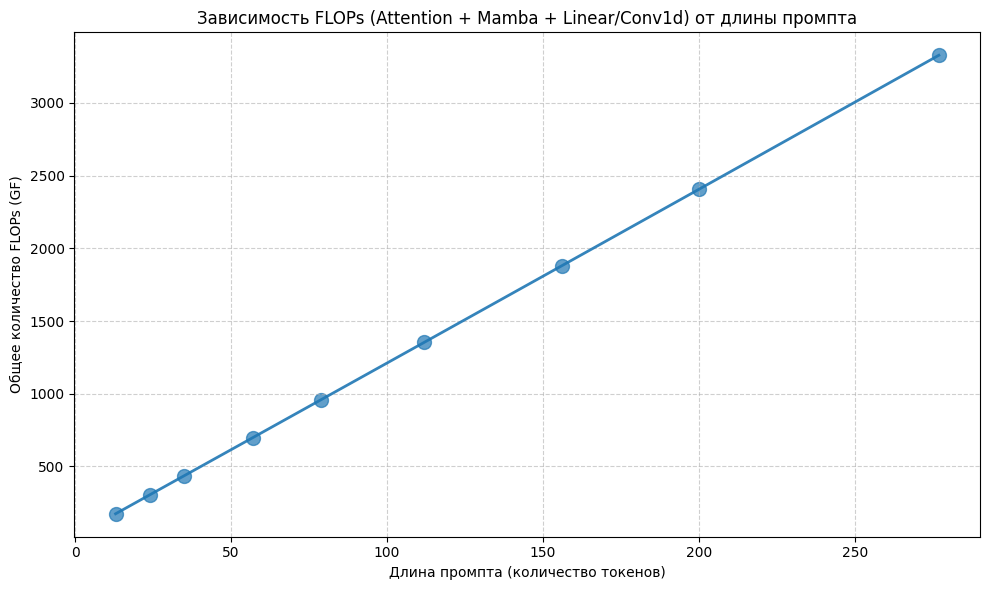

In [55]:
prompt_lengths = [s['prompt_length'] for s in stats_list]
total_flops_gf = [s['total_flops'] / 1e9 for s in stats_list]

plot_df = pd.DataFrame({
    'Prompt Length': prompt_lengths,
    'Total FLOPs (GF)': total_flops_gf
})

plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Prompt Length'], plot_df['Total FLOPs (GF)'], s=100, alpha=0.7)
plt.plot(plot_df['Prompt Length'], plot_df['Total FLOPs (GF)'], linewidth=2, alpha=0.9)
plt.title('Зависимость FLOPs (Attention + Mamba + Linear/Conv1d) от длины промпта')
plt.xlabel('Длина промпта (количество токенов)')
plt.ylabel('Общее количество FLOPs (GF)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('flops_vs_prompt_length.png')
plt.show()

# Оценка FLOPS

Вопрос, на который нужно ответить:
- Действительно ли у гибрида Mamba затраты не будут увеличиваться квадратично при увеличении длины контекста?

Скрипт ниже по сгенерированному выше отчету о слоях подсчитывает приблизительный FLOPS

In [56]:
import re
import numpy as np
import ast

def parse_file(file_path):
    """Читает layers_X.txt и приводит shapes к удобному виду"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    pattern = (
        r'\[(\d+)\]\s+(\S+)\s*\n'
        r'\s*Тип:\s*(\w+)\s*\n'
        r'\s*Время:\s*([\d.]+)\s*ms\s*\n'
        r'\s*Вход:\s*(.*?)\s*\n'
        r'\s*Выход:\s*(.*?)\s*(?=\n\[|\Z)'
    )
    matches = re.findall(pattern, content, re.DOTALL)

    ops = []
    for m in matches:
        op_id = int(m[0])
        name = m[1].strip()
        op_type = m[2].strip()
        time_ms = float(m[3])

        try:
            in_shape = ast.literal_eval(m[4].strip())
        except Exception:
            in_shape = None
        try:
            out_shape = ast.literal_eval(m[5].strip())
        except Exception:
            out_shape = None

        if isinstance(in_shape, list) and in_shape and isinstance(in_shape[0], tuple):
            in_shape = in_shape[0]
        if isinstance(out_shape, list) and out_shape and isinstance(out_shape[0], tuple):
            out_shape = out_shape[0]

        ops.append({
            'id': op_id,
            'name': name,
            'type': op_type,
            'time_ms': time_ms,
            'input_shape': in_shape,
            'output_shape': out_shape
        })

    return ops


def normalize_shape(shape):
    """Приводим shape к виду (batch, seq, dim)"""
    if shape is None:
        return None, None, None
    if isinstance(shape, tuple):
        if len(shape) == 3:
            return int(shape[0]), int(shape[1]), int(shape[2])
        if len(shape) == 2:
            return 1, int(shape[0]), int(shape[1])
        if len(shape) == 1:
            return 1, 1, int(shape[0])
    return None, None, None


def calculate_flops(operation):
    """Приблизительный FLOPs для одной операции по типу и размерностям"""
    op_type = operation['type']
    b, s, d = normalize_shape(operation["input_shape"])
    _, _, d_out = normalize_shape(operation["output_shape"])

    if b is None:
        return 0.0

    flops = 0.0

    # Linear: 2 * B * S * in * out
    if op_type == "Linear" and d and d_out:
        flops = 2.0 * b * s * d * d_out

    # Conv1d: 2 * B * C_in * C_out * L_out * K (считаем K=3 по умолчанию)
    elif op_type == "Conv1d":
        inp = operation["input_shape"]
        out = operation["output_shape"]
        if isinstance(inp, tuple) and len(inp) == 3 and isinstance(out, tuple) and len(out) == 3:
            B, C_in, L_in = inp
            _, C_out, L_out = out
            kernel_size = 3
            flops = 2.0 * B * C_in * C_out * L_out * kernel_size

    # RMSNorm: ~2 * B * S * D
    elif "RMSNorm" in op_type and d:
        flops = 2.0 * b * s * d

    # Активации: ~B * S * D
    elif op_type in ["SiLU", "GELUActivation", "SiLUActivation"] and d:
        flops = 1.0 * b * s * d

    # Остальные считаем пренебрежимо малыми для этой оценки
    return flops

In [57]:
def calculate_flops_for_report(file_path):
    operations = parse_file(file_path)

    print("=====================================================")
    print(f"Файл: {file_path}")
    print("=====================================================")

    type_groups = {}
    total_flops = 0.0
    total_time = 0.0
    total_count = 0

    for op in operations:
        flops = calculate_flops(op)
        op_type = op["type"]
        time_ms = op["time_ms"]

        total_flops += flops
        total_time += time_ms
        total_count += 1

        if op_type not in type_groups:
            type_groups[op_type] = {
                "count": 0,
                "flops": 0.0,
                "time": 0.0
            }

        type_groups[op_type]["count"] += 1
        type_groups[op_type]["flops"] += flops
        type_groups[op_type]["time"] += time_ms

    print(f"{'Тип операции':<28} {'Кол-во':>7} {'FLOPs (GF)':>14} {'% FLOPs':>10} {'Время (мс)':>12} {'avg ms':>10}")
    print("-" * 100)

    for t, st in sorted(type_groups.items(), key=lambda x: -x[1]["flops"]):
        count = st["count"]
        flops_gf = st["flops"] / 1e9
        percent = (st["flops"] / total_flops * 100) if total_flops > 0 else 0
        time_ms = st["time"]
        avg_ms = time_ms / count if count > 0 else 0

        print(f"{t:<28} {count:>7} {flops_gf:>14.3f} {percent:>9.1f}% {time_ms:>12.2f} {avg_ms:>10.3f}")

    print("-" * 80)
    print(f"{'ИТОГО':<28} {total_count:>7} {total_flops/1e9:>14.3f} {100.0:>9.1f}% {total_time:>12.2f}")
    print("=====================================================")

    return total_flops

In [58]:
calculate_flops_for_report("layers_2.txt")

Файл: layers_2.txt
Тип операции                  Кол-во     FLOPs (GF)    % FLOPs   Время (мс)     avg ms
----------------------------------------------------------------------------------------------------
Conv1d                            44        164.095      57.1%         4.44      0.101
Linear                           263        123.147      42.9%        34.44      0.131
Zamba2RMSNormGated                44          0.013       0.0%        16.90      0.384
Zamba2RMSNorm                     63          0.011       0.0%         8.51      0.135
SiLU                              44          0.007       0.0%         2.06      0.047
GELUActivation                    12          0.003       0.0%         0.55      0.046
Embedding                          1          0.000       0.0%         0.20      0.195
Zamba2RotaryEmbedding              1          0.000       0.0%         0.25      0.247
Zamba2MambaMixer                  38          0.000       0.0%      7358.45    193.643
Sequential

287276800000.0